# **Data Preprocessing: Stage Three**

1.	Splitting the training data (window under sampling #2 – added feature set)
-	Get the duration for all the species
-	From the species with the shortest duration, make 70% of that duration the benchmark for the training duration of all the species for balanced training
-	The remaining samples will be validation data
-	Introduce new features into the mix to strengthen the learning process (like RMS Energy, Chroma thing, another kind of spectrogram, etc) – Max 3 new features
-	Turn all the data into their respective new feature using the window process (maybe the top 2 most accurate window sizes, or top one) – e.g. a 4 second window of audio converted to four features (mel, chroma, etc) and do that for all the overlaps too. 
-	You basically do what is done in stage 2, with new features added to the data
-	Again, since all the audio is the same duration, the dimensions should be alright. I think we need to match the dimensions of all the new feature set too… shouldn’t really be an issue
-	Save that into a pkl file or something to use consistent data across all the models


Now we are strengthening the model’s ability to recognize bird species by adding new features they should look out for
We are adding features to just improve the quality of features being injected in the model

* Top window with features
* Second window with features
* Best between that with filtered audio

In [1]:
# Standard libraries
import numpy as np
import pandas as pd
import os
import time

# Libraries for audio
from IPython.display import Audio
import librosa
import librosa.display
import IPython.display as ipd

# Training and Testing Split
from sklearn.model_selection import train_test_split

# for normalization & avgpooling features
from sklearn.preprocessing import MinMaxScaler # to squeeze all the features to be within 0 and 1
import tensorflow as tf

# Operational
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import scipy.ndimage
from scipy.signal import butter, filtfilt
import random

# Feature Extraction

Turning the data into Mel-spectrograms 

In [2]:
npy_path = 'C:/Users/thato/Documents/Final-Year-Project/Dataset/Project-V2/train_audio_npy/'  # Path to audio npy files
save_path = 'C:/Users/thato/Documents/Final-Year-Project/Dataset/Project-V2/feature-extraction/Stage-3/'  # Where to save features
n_mels = 128
target_shape = (128,128)
sr = 16000

In [3]:
# Loading the train-validation split CSV
csv_path = 'C:/Users/thato/Documents/Final-Year-Project/Dataset/Project-V2/trainval-split/stage-3-trainval.csv'
trainval_data = pd.read_csv(csv_path)
train_data = trainval_data[trainval_data['set'] == 'tr']
val_data = trainval_data[trainval_data['set'] == 'val']

In [4]:
train_pkl_path = 'C:/Users/thato/Documents/Final-Year-Project/Dataset/Project-V2/feature-extraction/Stage-3/train_features_4s.pkl'
val_pkl_path = 'C:/Users/thato/Documents/Final-Year-Project/Dataset/Project-V2/feature-extraction/Stage-3/val_features_4s.pkl'


In [5]:
# Function to normalize audio data between 0 and 1
def normalize_audio(audio):
    return (audio - np.min(audio)) / (np.max(audio) - np.min(audio))


In [61]:
def bandpass_filter(audio, lowcut=600, highcut=7900, sr=sr, order=4):
    nyquist = 0.5 * sr  # Nyquist frequency
    low = lowcut / nyquist
    high = highcut / nyquist
    
    # Design Butterworth bandpass filter
    b, a = butter(order, [low, high], btype='band')
    
    # Apply filter to audio
    filtered_audio = filtfilt(b, a, audio)
    return filtered_audio

In [7]:
# Function to generate multiple features (Mel, RMS, Chroma, MFCC) with sliding window and overlap
def get_features_with_window(npy_file, filter=False, sr=sr, window_size=4, overlap=2, n_mels=128, hop_length=512, target_shape=(128, 128)):
    audio_data = np.load(npy_path + npy_file)
    audio_data = normalize_audio(audio_data)
    
    audio_duration = librosa.get_duration(y=audio_data, sr=sr)
    if audio_duration < window_size:
        return None  # Skip short samples
    
    # Calculate the step and overlap in samples
    step = int(window_size * sr)
    overlap_step = int(overlap * sr)
    
    features = []  # To store feature dictionaries
    
    # Create multiple windows with overlap
    for start in range(0, len(audio_data) - step + 1, overlap_step):
        windowed_data = audio_data[start:start + step]
        if filter:
            windowed_data = bandpass_filter(windowed_data)
        
        
        # Generate Mel Spectrogram
        mel_spec = librosa.feature.melspectrogram(y=windowed_data, sr=sr, n_mels=n_mels, hop_length=hop_length)
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
        mel_spec_db = (mel_spec_db - mel_spec_db.min()) / (mel_spec_db.max() - mel_spec_db.min())
        mel_resized = scipy.ndimage.zoom(mel_spec_db, (target_shape[0] / mel_spec_db.shape[0], target_shape[1] / mel_spec_db.shape[1]))
        
        # Generate RMS Energy
        rms_energy = librosa.feature.rms(y=windowed_data)
        rms_resized = scipy.ndimage.zoom(rms_energy, (target_shape[0] / rms_energy.shape[0], target_shape[1] / rms_energy.shape[1]))
        
        # Generate Chroma Frequencies
        chroma = librosa.feature.chroma_stft(y=windowed_data, sr=sr)
        chroma_resized = scipy.ndimage.zoom(chroma, (target_shape[0] / chroma.shape[0], target_shape[1] / chroma.shape[1]))
        
        # Generate MFCC
        mfcc = librosa.feature.mfcc(y=windowed_data, sr=sr, n_mfcc=13)
        mfcc_resized = scipy.ndimage.zoom(mfcc, (target_shape[0] / mfcc.shape[0], target_shape[1] / mfcc.shape[1]))
        
        # Append the feature set to the list as a dictionary
        features.append({
            "mel_spectrogram": mel_resized,
            "rms_energy": rms_resized,
            "chroma": chroma_resized,
            "mfcc": mfcc_resized
        })
    
    return features  # Returns a list of dictionaries containing all features for each window


In [114]:
def plot_all_features(npy_file, window_idx, filter=False, sr=sr, window_size=6, overlap=3, n_mels=128, hop_length=512, target_shape=(128, 128)):
    audio_data = np.load(npy_path + npy_file)
    # audio_data = normalize_audio(audio_data)
    
    # Get the duration of the audio and ensure it's long enough
    audio_duration = librosa.get_duration(y=audio_data, sr=sr)
    if audio_duration < window_size:
        print("Audio too short for the specified window size.")
        return None
    
    # Calculate the step and overlap in samples
    step = int(window_size * sr)
    overlap_step = int(overlap * sr)
    
    # Get the start and end points of the window
    start = window_idx * overlap_step
    end = start + step
    
    if end > len(audio_data):
        print(f"Window index {window_idx} exceeds audio length.")
        return None
    
    # Extract the windowed audio
    windowed_data = audio_data[start:end]
    if filter:
            windowed_data = bandpass_filter(windowed_data)

    
    # Generate the mel spectrogram
    mel_spec = librosa.feature.melspectrogram(y=windowed_data, sr=sr, n_mels=n_mels, hop_length=hop_length)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    mel_spec_db = (mel_spec_db - mel_spec_db.min()) / (mel_spec_db.max() - mel_spec_db.min())
    mel_resized = scipy.ndimage.zoom(mel_spec_db, (target_shape[0] / mel_spec_db.shape[0], target_shape[1] / mel_spec_db.shape[1]))
    
    # Generate the RMS Energy
    rms_energy = librosa.feature.rms(y=windowed_data)
    rms_resized = scipy.ndimage.zoom(rms_energy, (target_shape[0] / rms_energy.shape[0], target_shape[1] / rms_energy.shape[1]))
    
    # Generate the Chroma Frequencies
    chroma = librosa.feature.chroma_stft(y=windowed_data, sr=sr)
    chroma_resized = scipy.ndimage.zoom(chroma, (target_shape[0] / chroma.shape[0], target_shape[1] / chroma.shape[1]))
    
    # Generate the MFCCs
    mfcc = librosa.feature.mfcc(y=windowed_data, sr=sr, n_mfcc=13)
    mfcc_resized = scipy.ndimage.zoom(mfcc, (target_shape[0] / mfcc.shape[0], target_shape[1] / mfcc.shape[1]))
    
    # Plot all features
    plt.figure(figsize=(20, 12))

    # Plot Mel Spectrogram
    plt.subplot(2, 2, 1)
    librosa.display.specshow(mel_resized, sr=sr, hop_length=hop_length, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Mel Spectrogram')

    # Plot RMS Energy
    plt.subplot(2, 2, 2)
    librosa.display.specshow(rms_resized, sr=sr, hop_length=hop_length, x_axis='time')
    plt.colorbar(format='%+2.0f')
    plt.title('RMS Energy')

    # Plot Chroma Frequencies
    plt.subplot(2, 2, 3)
    librosa.display.specshow(chroma_resized, sr=sr, hop_length=hop_length, x_axis='time', y_axis='chroma')
    plt.colorbar()
    plt.title('Chroma Frequencies')

    # Plot MFCC
    plt.subplot(2, 2, 4)
    librosa.display.specshow(mfcc_resized, sr=sr, hop_length=hop_length, x_axis='time')
    plt.colorbar()
    plt.title('MFCC')

    plt.tight_layout()
    plt.show()

    # Play the audio for the selected window
    print(f"Playing audio window {window_idx} from {start/sr:.2f}s to {end/sr:.2f}s:")
    ipd.display(ipd.Audio(windowed_data, rate=sr))


### Visualizing Features

As you can see by changing the filter from True to False, choosing to use the filter enhances the features strongly.

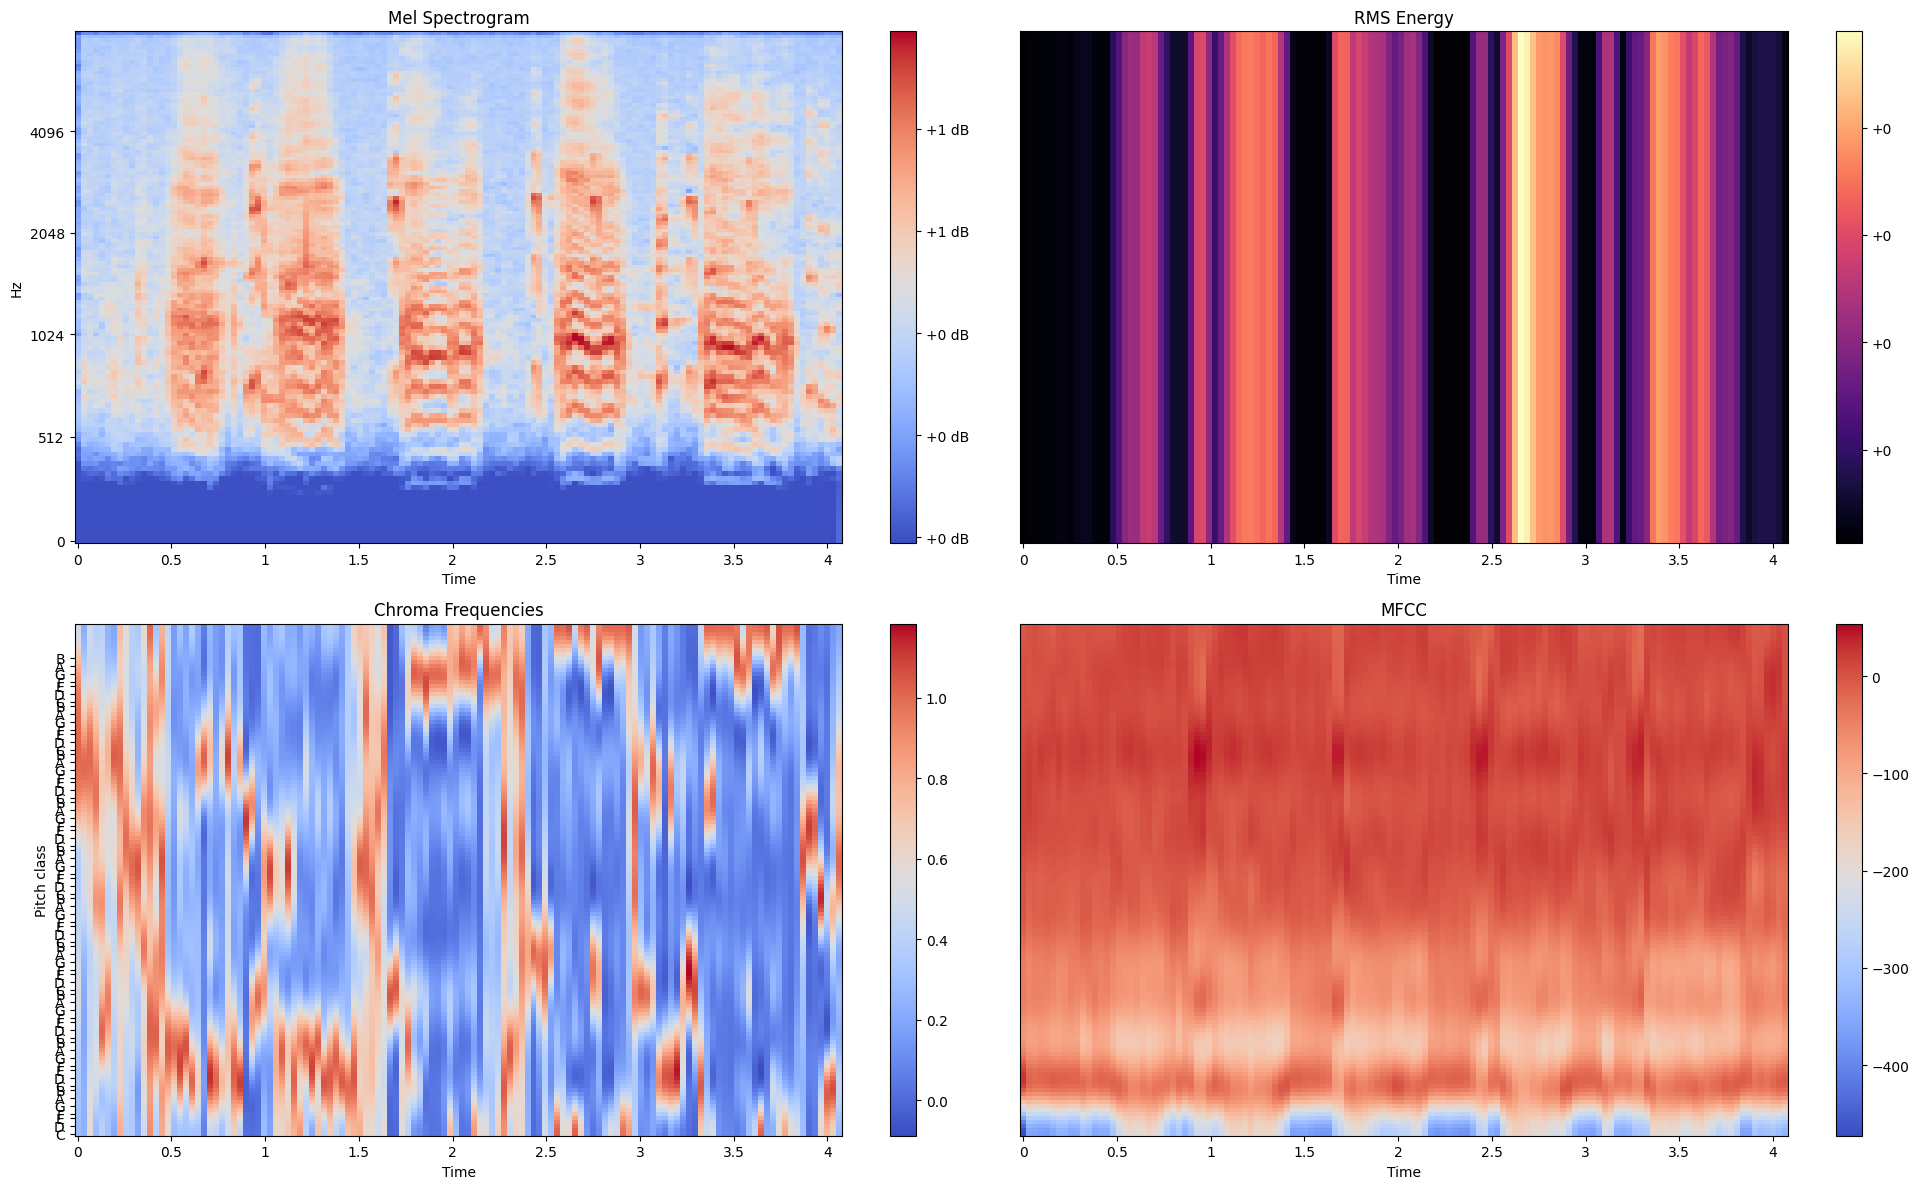

Playing audio window 0 from 0.00s to 6.00s:


In [118]:
npy_file = 'greegr/XC361135.npy'
window_idx = 0 # 10, 2 @ 4s2
filter = True

plot_all_features(npy_file, window_idx, filter) # Plotting with the filter. 

## Processing the training data

In [85]:
train_features = {}
for _, row in tqdm(train_data.iterrows(), desc="Processing training features", total=len(train_data)):
    npy_file = row['filename_npy']
    label = row['primary_label']
    
    # Generate features for the file
    feature_windows = get_features_with_window(npy_file)
    if feature_windows is None:
        continue  # Skip short samples
    
    # Save each window's features in a dictionary along with the label
    for i, feature_set in enumerate(feature_windows):
        key = f"{npy_file}_window_{i}"
        train_features[key] = (feature_set, label)

Processing training features:   0%|          | 0/933 [00:00<?, ?it/s]c:\Users\thato\AppData\Local\Programs\Python\Python312\Lib\site-packages\librosa\core\pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
Processing training features: 100%|██████████| 933/933 [05:49<00:00,  2.67it/s]


In [87]:
with open(train_pkl_path, 'wb') as f:
    pickle.dump(train_features, f)

## Processing the validation data

In [88]:
val_features = {}
for _, row in tqdm(val_data.iterrows(), desc="Processing training features", total=len(val_data)):
    npy_file = row['filename_npy']
    label = row['primary_label']
    
    # Generate features for the file
    feature_windows = get_features_with_window(npy_file)
    if feature_windows is None:
        continue  # Skip short samples
    
    # Save each window's features in a dictionary along with the label
    for i, feature_set in enumerate(feature_windows):
        key = f"{npy_file}_window_{i}"
        val_features[key] = (feature_set, label)

Processing training features: 100%|██████████| 1824/1824 [31:25<00:00,  1.03s/it]  


In [90]:
# Save validation mel spectrograms to pickle
with open(val_pkl_path, 'wb') as f:
    pickle.dump(val_features, f)

## Plotting the features

In [91]:
# Function to plot the features (Mel spectrogram, RMS Energy, Chroma, MFCC)
def plot_features(feature_set, title_prefix="Window Features"):
    fig, axs = plt.subplots(2, 2, figsize=(12, 8))
    
    # Mel Spectrogram
    axs[0, 0].imshow(feature_set["mel_spectrogram"], aspect='auto', origin='lower', cmap='magma')
    axs[0, 0].set_title(f'{title_prefix}: Mel Spectrogram')
    
    # RMS Energy
    axs[0, 1].imshow(feature_set["rms_energy"], aspect='auto', origin='lower', cmap='inferno')
    axs[0, 1].set_title(f'{title_prefix}: RMS Energy')
    
    # Chroma
    axs[1, 0].imshow(feature_set["chroma"], aspect='auto', origin='lower', cmap='coolwarm')
    axs[1, 0].set_title(f'{title_prefix}: Chroma Frequencies')
    
    # MFCC
    axs[1, 1].imshow(feature_set["mfcc"], aspect='auto', origin='lower', cmap='viridis')
    axs[1, 1].set_title(f'{title_prefix}: MFCC')
    
    # Layout adjustment
    plt.tight_layout()
    plt.show()

In [93]:
# Function to choose a window and plot its features
def choose_and_plot_window(train_features, specific_key=None):
    # If specific_key is provided, use that; otherwise, choose a random key
    if specific_key is None:
        chosen_key = random.choice(list(train_features.keys()))
    else:
        chosen_key = specific_key

    # Extract features and label from the selected window
    feature_set, label = train_features[chosen_key]
    
    # Plot the features for the chosen window
    print(f"Chosen window: {chosen_key}, Label: {label}")
    plot_features(feature_set, title_prefix=f"Species: {label}")

In [ ]:
# file_with_window = 'fotdro5/XC153869.npy_window_1'
# original_file = file_with_window.rsplit('_', 1)[0]  # Split from the right, remove the last part after "_"
# print(original_file)

Chosen window: fotdro5/XC153869.npy_window_1, Label: fotdro5


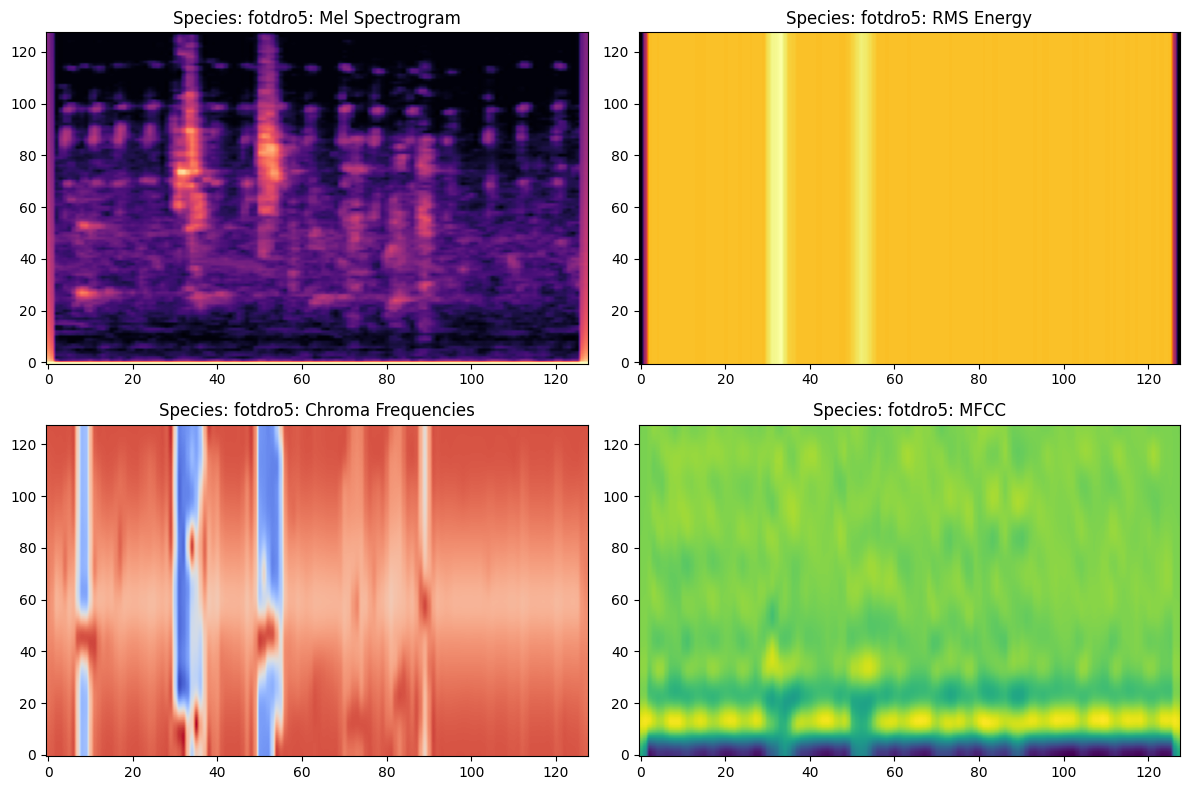

In [94]:
choose_and_plot_window(train_features)

# Confirming that the pickle files were saved correctly:

In [95]:
with open(train_pkl_path, 'rb') as f:
    train_features_pkl = pickle.load(f)

Chosen window: gargan/XC365510.npy_window_43, Label: gargan


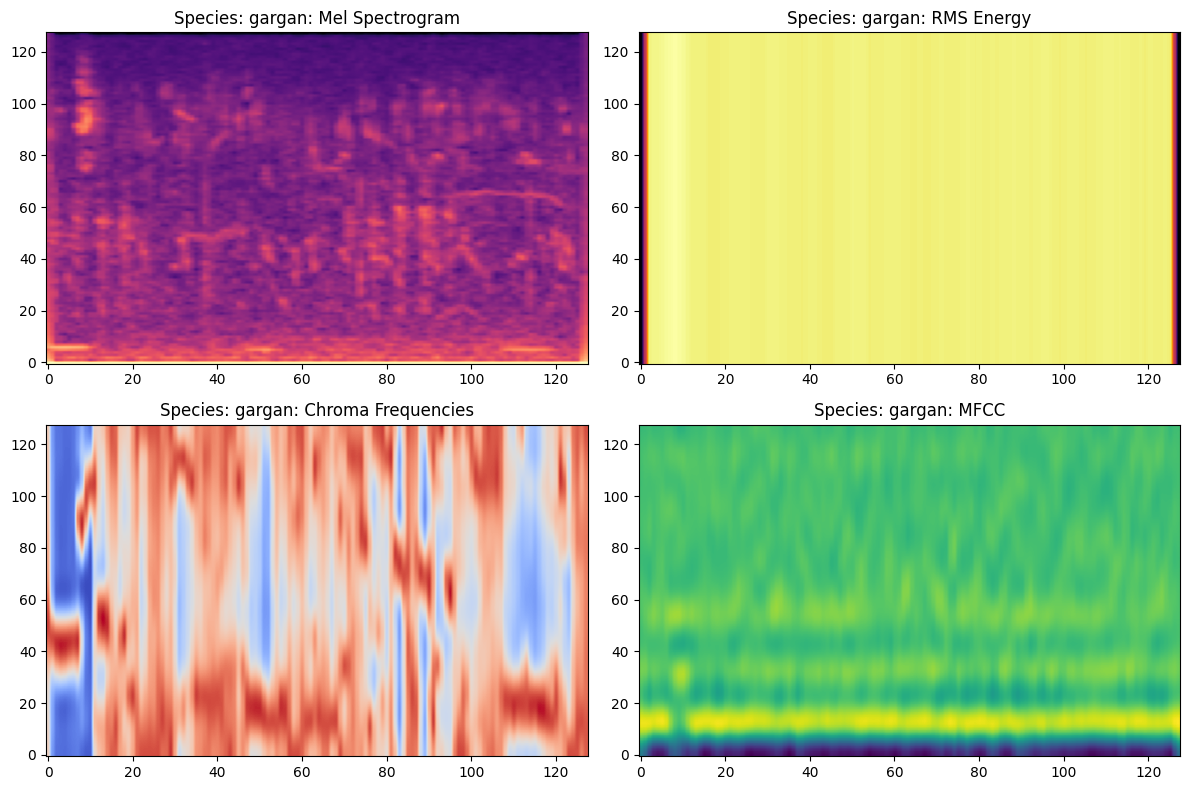

In [96]:
choose_and_plot_window(train_features_pkl)